# Pseudotime Analysis

This notebook is a continuation of the Cluster Analysis tutorial, and assumes you are working with a preprocessed and annotated adata object (i.e., have gotten through the point of identifying and annotating clusters). In this tutorial, we will investigate differentiation trajectories in our dataset.

This notebook is largely adapted from an [ipython notebook](https://github.com/theislab/single-cell-tutorial) provided by the Theis Lab as part of their Molecular Systems Biology submission "Current best practices in single‐cell RNA‐seq analysis: a tutorial" ([Luecken and Theis, 2019](https://doi.org/10.15252/msb.20188746)). Both the notebook and paper are worth checking out to get a more in-depth idea of the steps involved with scRNA-seq analysis (and the "best" ways to do them!).

For these tutorials, we will be working with a publicly available scRNA-seq dataset of human cerebral organoids generated using 10x Genomics and preprocessed using Cell Ranger ([Kanton et al., 2019](https://www.nature.com/articles/s41586-019-1654-9#citeas)). This dataset is used in an excellent [scRNA-seq tutorial](https://github.com/quadbiolab/scRNAseq_analysis_vignette/blob/master/Tutorial.md#now-lets-start-part-1) using R and Seurat by Zhisong He and Barbara Treutlein, which we also highly recommend.

# Table of Contents

* [1 What is Pseudotime Analysis?](#1-What-is-Pseudotime-Analysis?)
* [2 Setting Up the Coding Environment](#2-Setting-Up-the-Coding-Environment)
* [3 Reading in the Data](#3-Reading-in-the-Data)
* [4 Preparing the Data](#4-Preparing-the-Data)
* [5 Slingshot](#5-Slingshot)

# 1 What is Pseudotime Analysis?

Pseudotime analysis (also called pseudotime inference or trajectory inference) aims to infer the ordering of cells along a lineage based on gene expression profiles measured by scRNA-seq. Pseudotime is a time-like variable, which indicates the relative position a cell takes in a lineage. Remember, your typical scRNA-seq is static, i.e. the cells were collected at one single timepoint. However, in your scRNA-seq dataset there are cells that are representative of different stages of differentiation and development. Therefore, by establishing a temporal dimension in a static scRNA-seq dataset, we can look at the expression dynamics of individual genes along with continuous cell-state changes. If a gene's mean expression changes along pseudotime, then that gene is differenitally expressed and is likely to play an important role in the underlying cellular process that gives rise to the pseudotime (i.e., that gene might be an important driver in a cell type's differentiation process).

There are tons of tools out there to perform pseudotime analysis. [*dynverse*](https://dynverse.org/) is a collection of R packages aimed at supporting the trajectory inference community, and offers a catalog of various methods as well as comparisons between the various methods so you can pick the right tool for your dataset. For this tutorial, we will be using `slingshot` to identify our trajectory structure and `tradeSeq` to look at differential gene expression in our `slingshot`-derived lineages.

Like several other pseudotime inference methods, `slingshot` works by using the generalized additive model (GAM) to fit each individual gene's expression level in a cell as a smooth-curve function of the cell's inferred pseudotime. `tradeSeq` uses the negative binomial generalized additive model (NB-GAM) to model the relationshp between each individual gene's expression in a cell and the cell's pseudotime.

Due to time and compute power constraints we will not be going over RNA velocity in-depth in this tutorial, but it is a pretty cool tool to know about. RNA velocity can predict the future state of individual cells (on a timescale of hours) by using the ratio of unspliced to spliced mRNA. Upstream processing is quite intensive, which requires the use of a cluster server. Downstream processing can by done on your local machine, and tools like [`scVelo`](https://scvelo.readthedocs.io/index.html) make it a breeze to incorporate RNA velocity analysis into a scanpy workflow. You can read more about RNA velocity [here](https://dx.doi.org/10.1038%2Fs41586-018-0414-6).

One last thing. It's always best to validate the results of one pseudotime analysis method by using a second independent pseudotime analysis method. For instance, you could use both `slingshot` and RNA velocity to look at trajectory structures, and if you see the same trajectory structures in both methods then that supports that you are seeing something reflective of true biology.

# 2 Setting Up the Coding Environment

Just like in our previous two tutorials, we need to set up our jupyter notebook and load in all of the python modules, packages, and libraries we need for scRNA-seq pseudotime analysis. We are going to be working with the `slingshot` and `tradeSeq` packages, which are both written in R. In our Preprocess tutorial we used `scran`, another R package, and were able to integrate R into our python notebook by using the `rpy2` interface. The `anndata2ri` package takes care of the conversion from an *AnnData* (adata) object to a *SingleCellExperiment* object in R. You might also remember that we mentioned that the convention of scRNA-seq data matrix storage in R (genes x cells) is opposite to python (cells x genes). `anndata2ri` takes care of transposing the data matrix for us. Nifty, right?

Note: there are ways that you can open your saved .h5ad adata object directly into an R environment too. Check out the [`zellkonverter`](https://bioconductor.org/packages/release/bioc/html/zellkonverter.html) package, for instance.

In [1]:
# main scRNA-seq analysis toolkit
import scanpy as sc

# data visualization
import matplotlib.pyplot as plt

# handles warnings; we are importing this to actually suppress some annoyting warning messages downstream
import warnings

# R-to-python conversion; for the preprocessing notebook we use this for the normalization step (scran)
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri
import anndata2ri
from rpy2.rinterface import RRuntimeWarning

In [2]:
# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Automatically convert rpy2 outputs to pandas dataframes
numpy2ri.activate()
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(2,2) # rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(dpi=200, dpi_save=300, format='ps') # scanpy figure parameters
#sc.logging.print_versions() # prints out version info for modules/packages/libraries used in the notebook. Important for reproducibility! 

In [3]:
%%R

library(slingshot)
library(tradeSeq)
library(ggplot2)
library(RColorBrewer)

In [4]:
# Files and Directories
sc.settings.figdir = './figures/'
results = './results/scanpy_tutorial.h5ad'

# 3 Reading in the Data

In [5]:
# load in saved adata object
adata = sc.read(results)

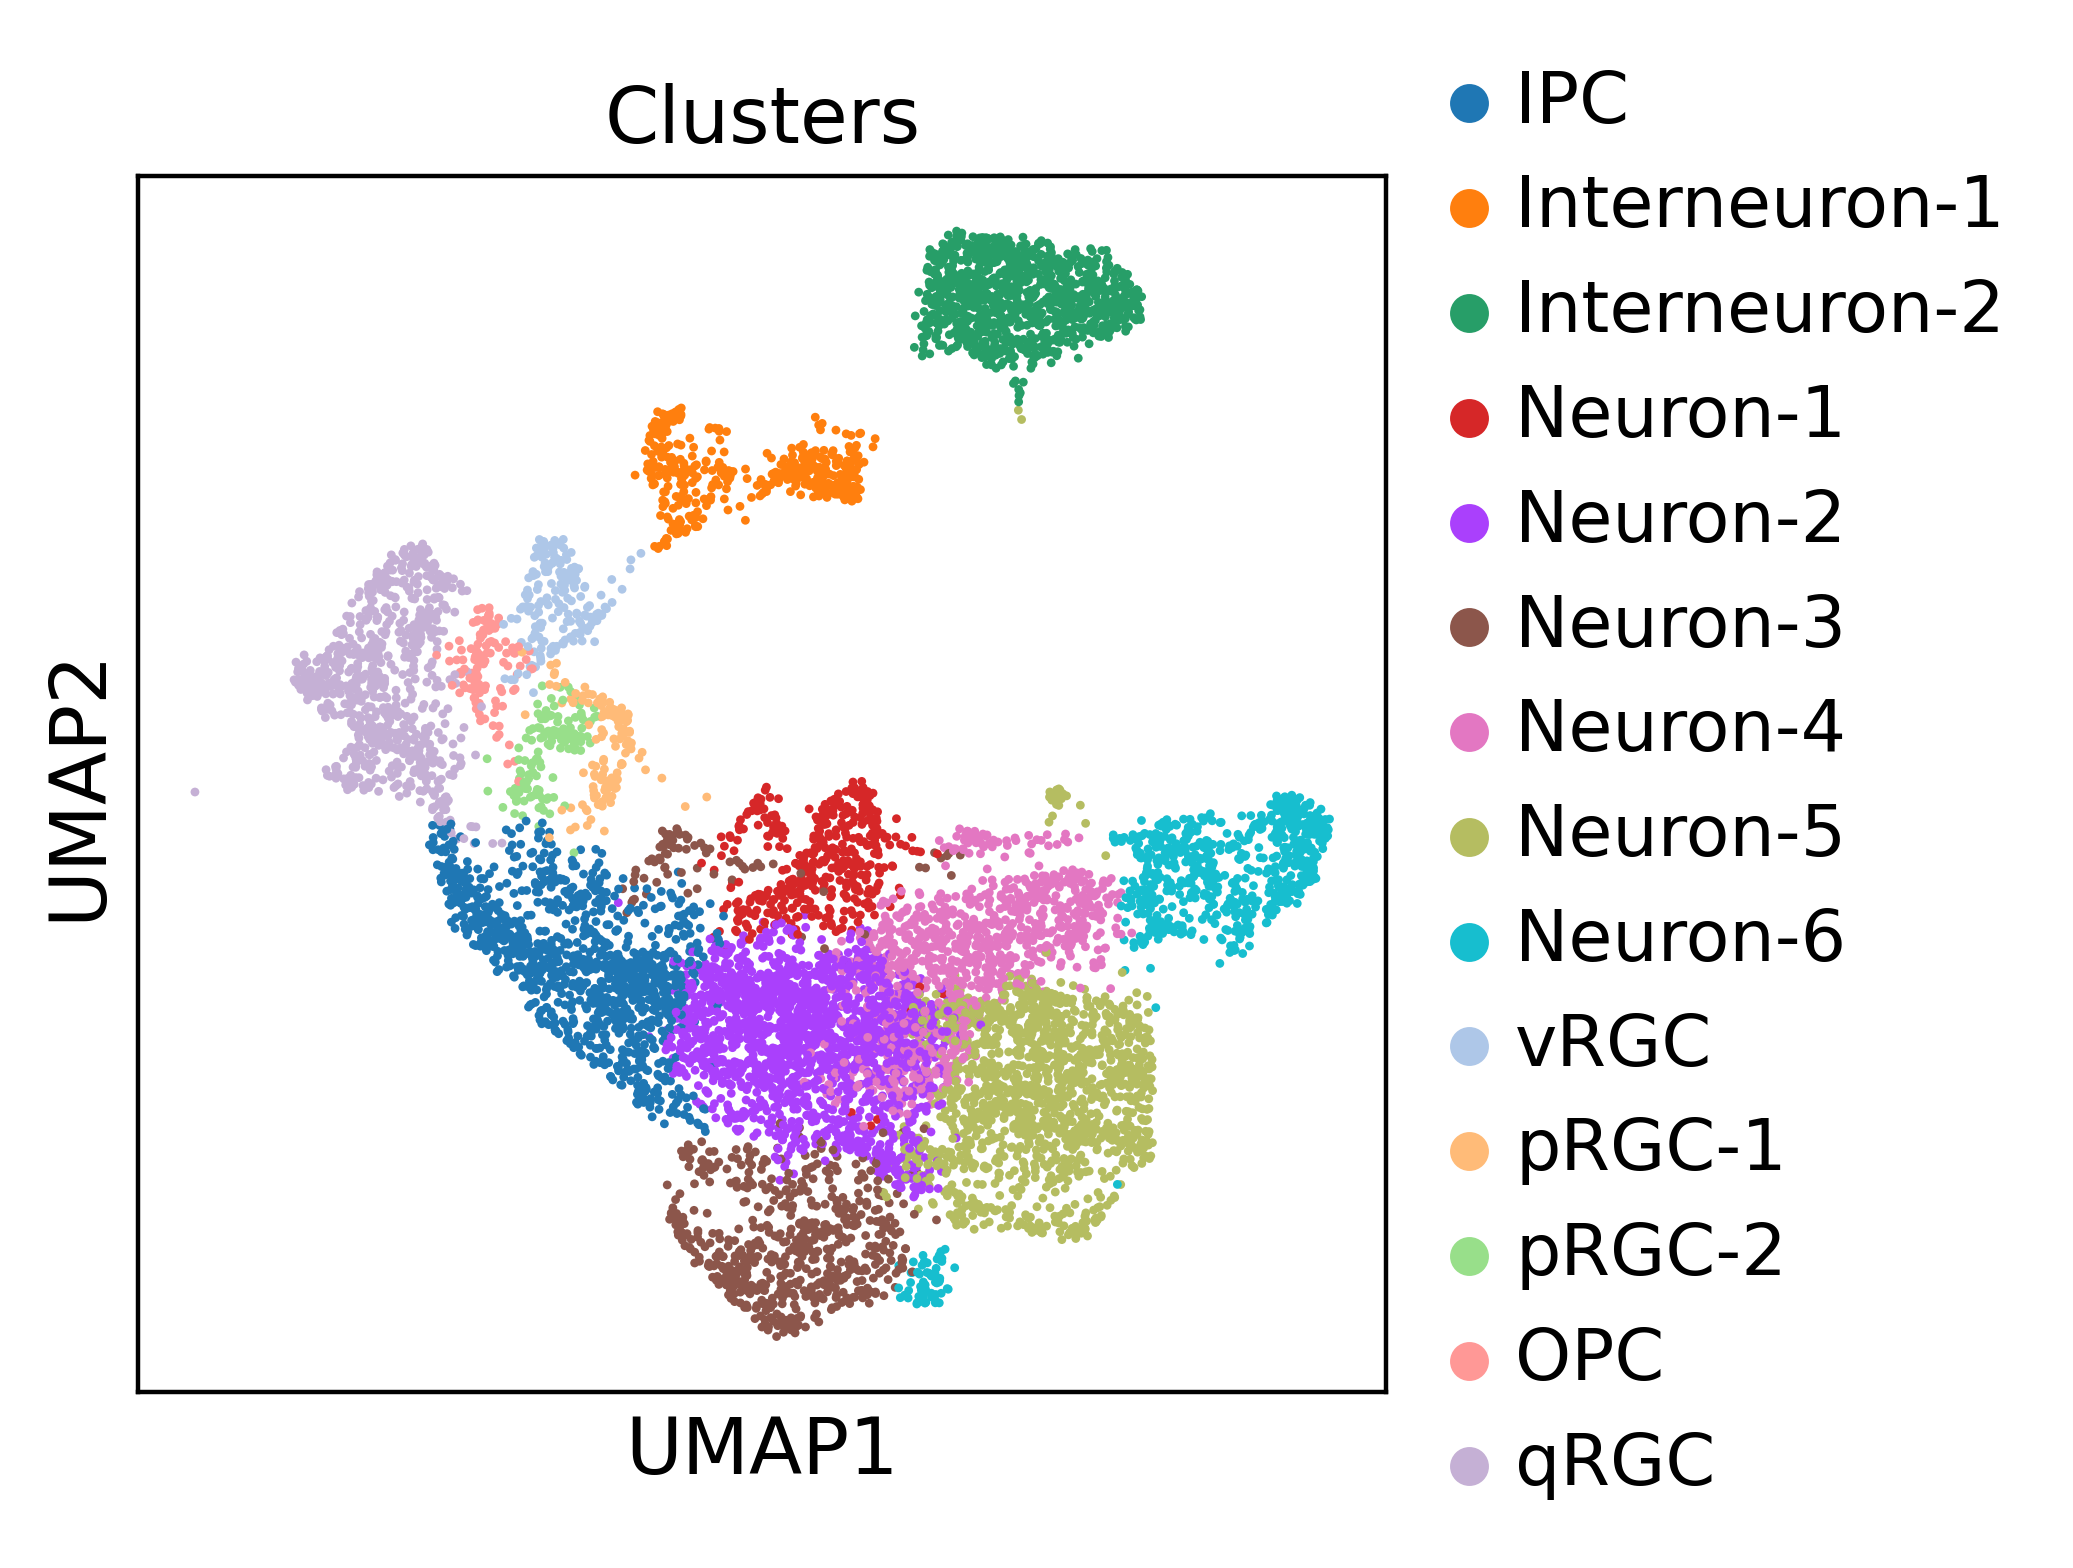

In [6]:
sc.pl.umap(adata, color=['clusters'], 
                  title=['Clusters'],
                  wspace = 0.5, 
                  size = 10)

# 4 Preparing the Data

In order to do trajectory inference, we first need to prepare our data. Because trajectory inference and measuring gene expression changes over pseudotime can by a computationally expensive process, we'll first subset our dataset to only include highly variable genes.

In [7]:
# Subset to highly variable genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000, subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Trajectory inference is often performed on PCA-reduced data, so next we'll assess how many principal components (PCs) should be included. We can do this by using the 'elbow method', which is essentially looking for the 'elbow' in a plot of the variance ratio explained per PC.

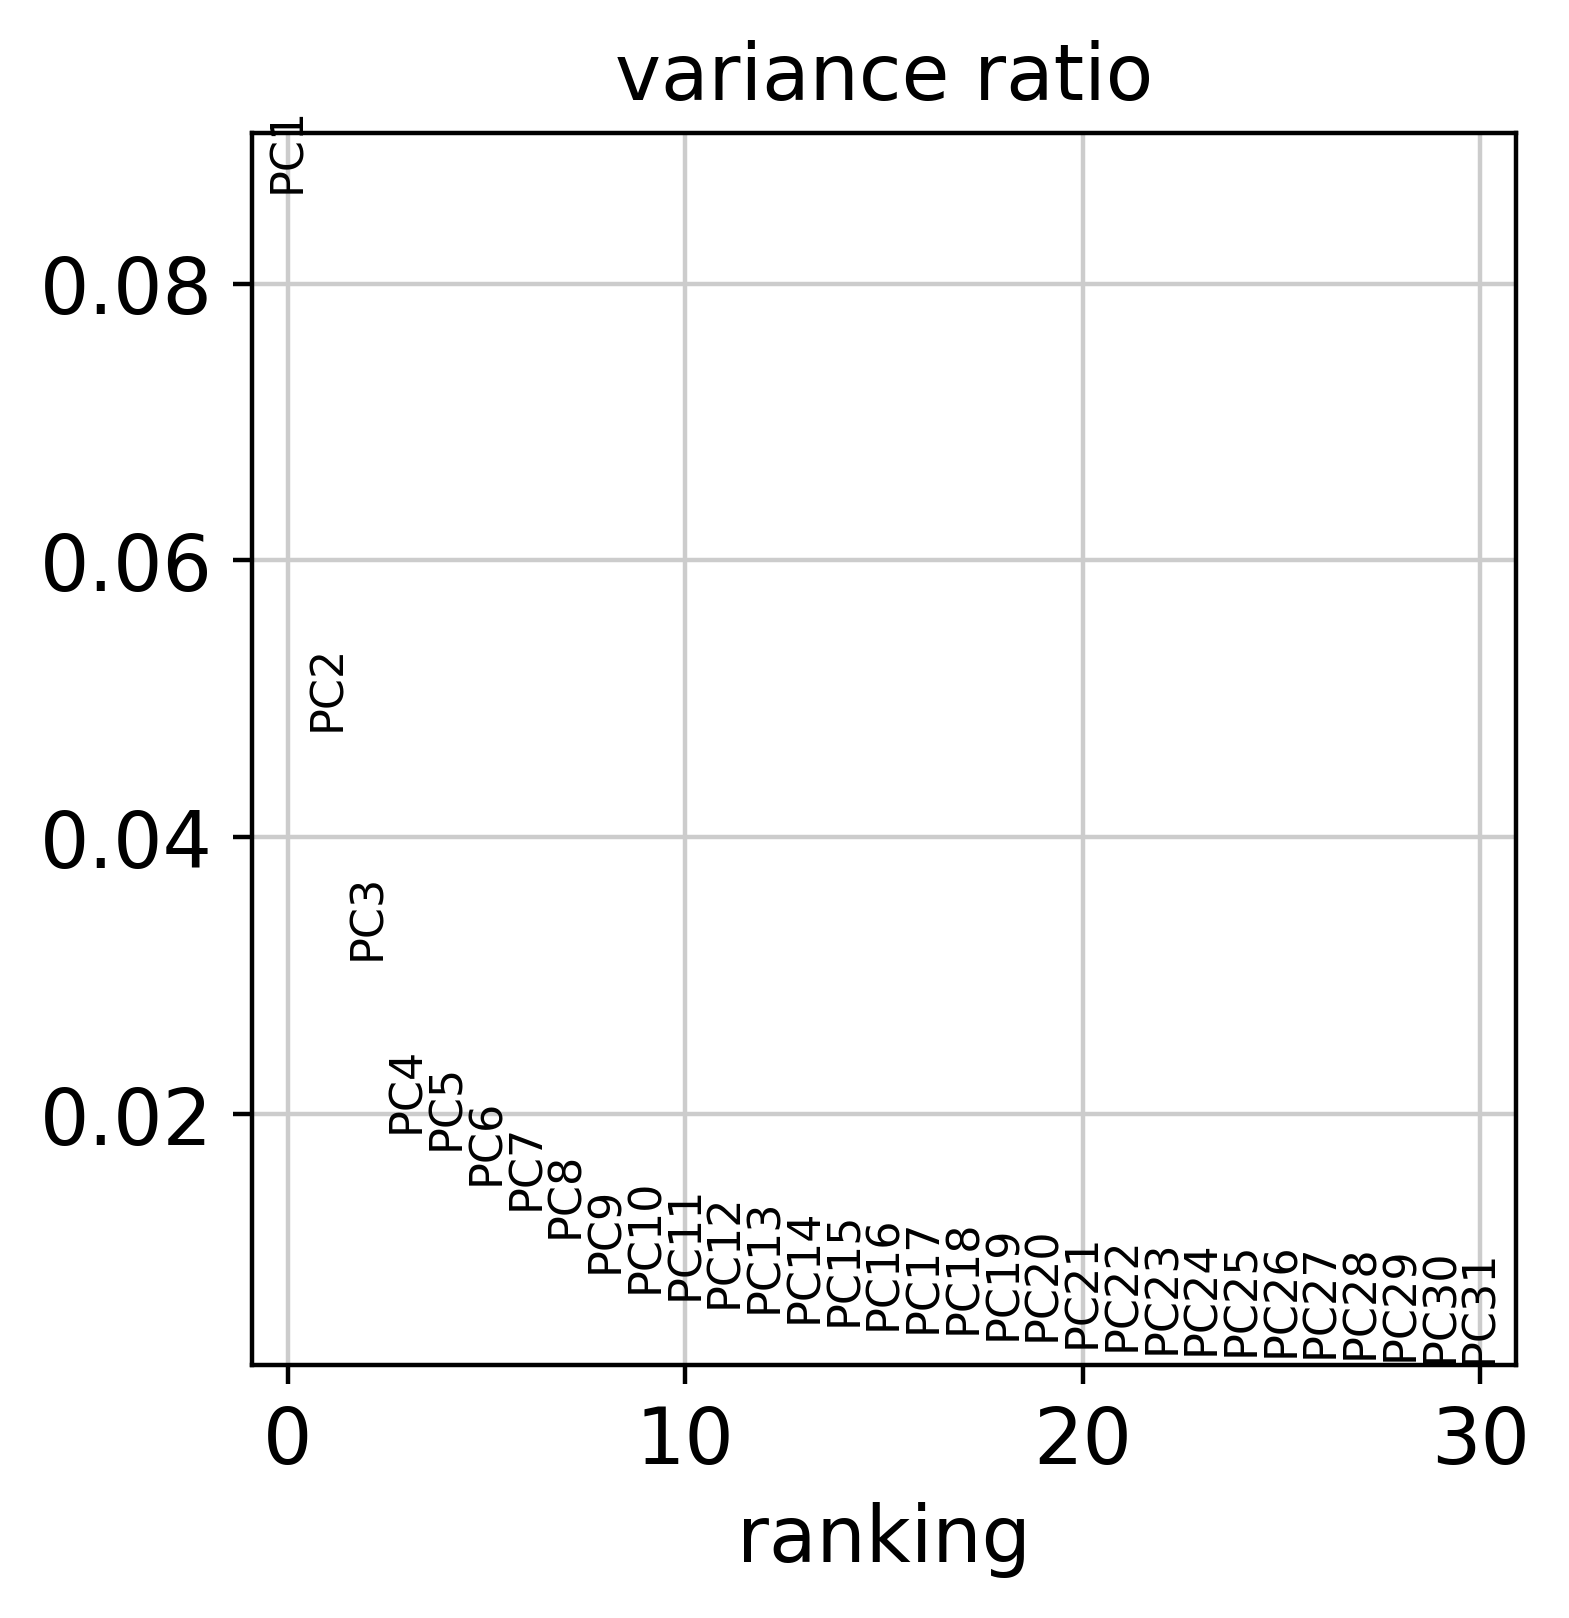

In [8]:
sc.pl.pca_variance_ratio(adata)

From this plot, we can see the elbow is around PC9, so we'll use the first six PCs for slingshot.

In [9]:
# Include PCs identified by elbow plot
adata.obsm['X_pca'] = adata.obsm['X_pca'][:,0:9]

# 5 Slingshot

Now that our data is prepared (the previous steps were all done using python), we can move into R and perform our trajecory analysis using slingshot. First, we will just move our data into R and then look at it in PCA space.

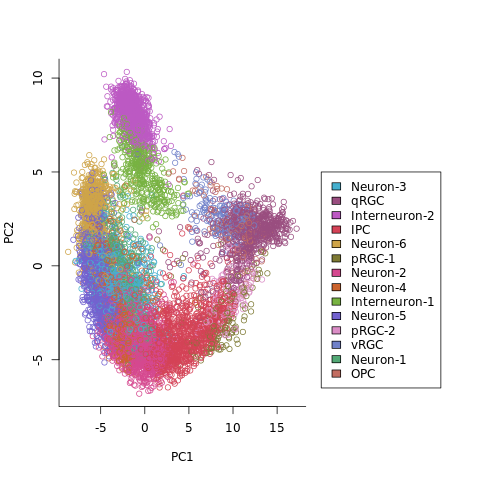

In [12]:
%%R -i adata

# Slingshot

# Plot the data on a two principal component representation
color_map = c("#d44256", "#77b241", "#bc59c3", "#52a875", "#d5488f", "#45b0cf", "#cb632d", "#7262cf",
              "#cea448", "#7081c9", "#7d7933", "#db8dc6", "#c26d61", "#994d7f")
par(xpd=TRUE, mar=par()$mar+c(0,0,0,10))
plot(reducedDims(adata)$PCA[,1], reducedDims(adata)$PCA[,2], 
     col=color_map[colData(adata)$clusters], bty='L', xlab='PC1', ylab='PC2')
legend(locator(1), x=20, y=5, legend=unique(colData(adata)$clusters),       
       fill=color_map[as.integer(unique(colData(adata)$clusters))])

Now we will find trajectories using slingshot. We can use slingshot in either an unbiased or guided approach. In both cases, we need to select a single starting cluster. Then for the guided approach, we can also provide slingshot a list of terminal clusters (i.e., differentiated cell types). Let's try out both.

In [13]:
%%R

# Determine if an unbiased _start or guided _startend approach is best

print("1:")
adata_start <- slingshot(adata, clusterLabels = 'clusters', reducedDim = 'PCA', start.clus='qRGC')
print(SlingshotDataSet(adata_start))

print("")
print("2:")
adata_startend <- slingshot(adata, clusterLabels = 'clusters', reducedDim = 'PCA', start.clus='qRGC', 
                            end.clus=c('Neuron-5', 'Neuron-6', 'Interneuron-2', 'OPC'))
print(SlingshotDataSet(adata_startend))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
    9490          9

lineages: 5 
Lineage1: qRGC  OPC  pRGC-2  IPC  Neuron-2  Neuron-4  Neuron-5  Neuron-3  
Lineage2: qRGC  OPC  pRGC-2  IPC  Neuron-2  Neuron-1  Interneuron-1  Interneuron-2  
Lineage3: qRGC  OPC  pRGC-2  IPC  Neuron-2  Neuron-4  Neuron-5  Neuron-6  
Lineage4: qRGC  OPC  pRGC-2  pRGC-1  
Lineage5: qRGC  OPC  vRGC  

curves: 5 
Curve1: Length: 45.312	Samples: 5380.69
Curve2: Length: 46.135	Samples: 4821.3
Curve3: Length: 49.397	Samples: 5848.92
Curve4: Length: 36.12	Samples: 910.1
Curve5: Length: 42.844	Samples: 734.81
[1] ""
[1] "2:"
class: SlingshotDataSet 

 Samples Dimensions
    9490          9

lineages: 7 
Lineage1: qRGC  pRGC-2  IPC  Neuron-2  Neuron-1  Interneuron-1  Interneuron-2  
Lineage2: qRGC  pRGC-2  IPC  Neuron-2  Neuron-4  Neuron-6  
Lineage3: qRGC  pRGC-2  IPC  Neuron-2  Neuron-4  Neuron-5  
Lineage4: qRGC  pRGC-2  IPC  Neuron-2  Neuron-3  
Lineage5: qRGC  pRGC-2  pRGC-1  
Lineage6: qRGC  pRGC-2  

In [16]:
import numpy as np
clusters_to_include = [g for g in adata.obs['clusters'].cat.categories if (g.startswith('qRGC') 
                                                                        or g.startswith('IPC')
                                                                        or g.startswith('Neuron-1')
                                                                        or g.startswith('vRGC')
                                                                        or g.startswith('Interneuron-1'))]

adata_test = adata[np.isin(adata.obs['clusters'], clusters_to_include),:].copy()

In [19]:
sc.pp.filter_genes(adata_test, min_cells = 1)
sc.pp.highly_variable_genes(adata_test, flavor='cell_ranger', n_top_genes=4000, subset=True)

filtered out 572 genes that are detected in less than 1 cells
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


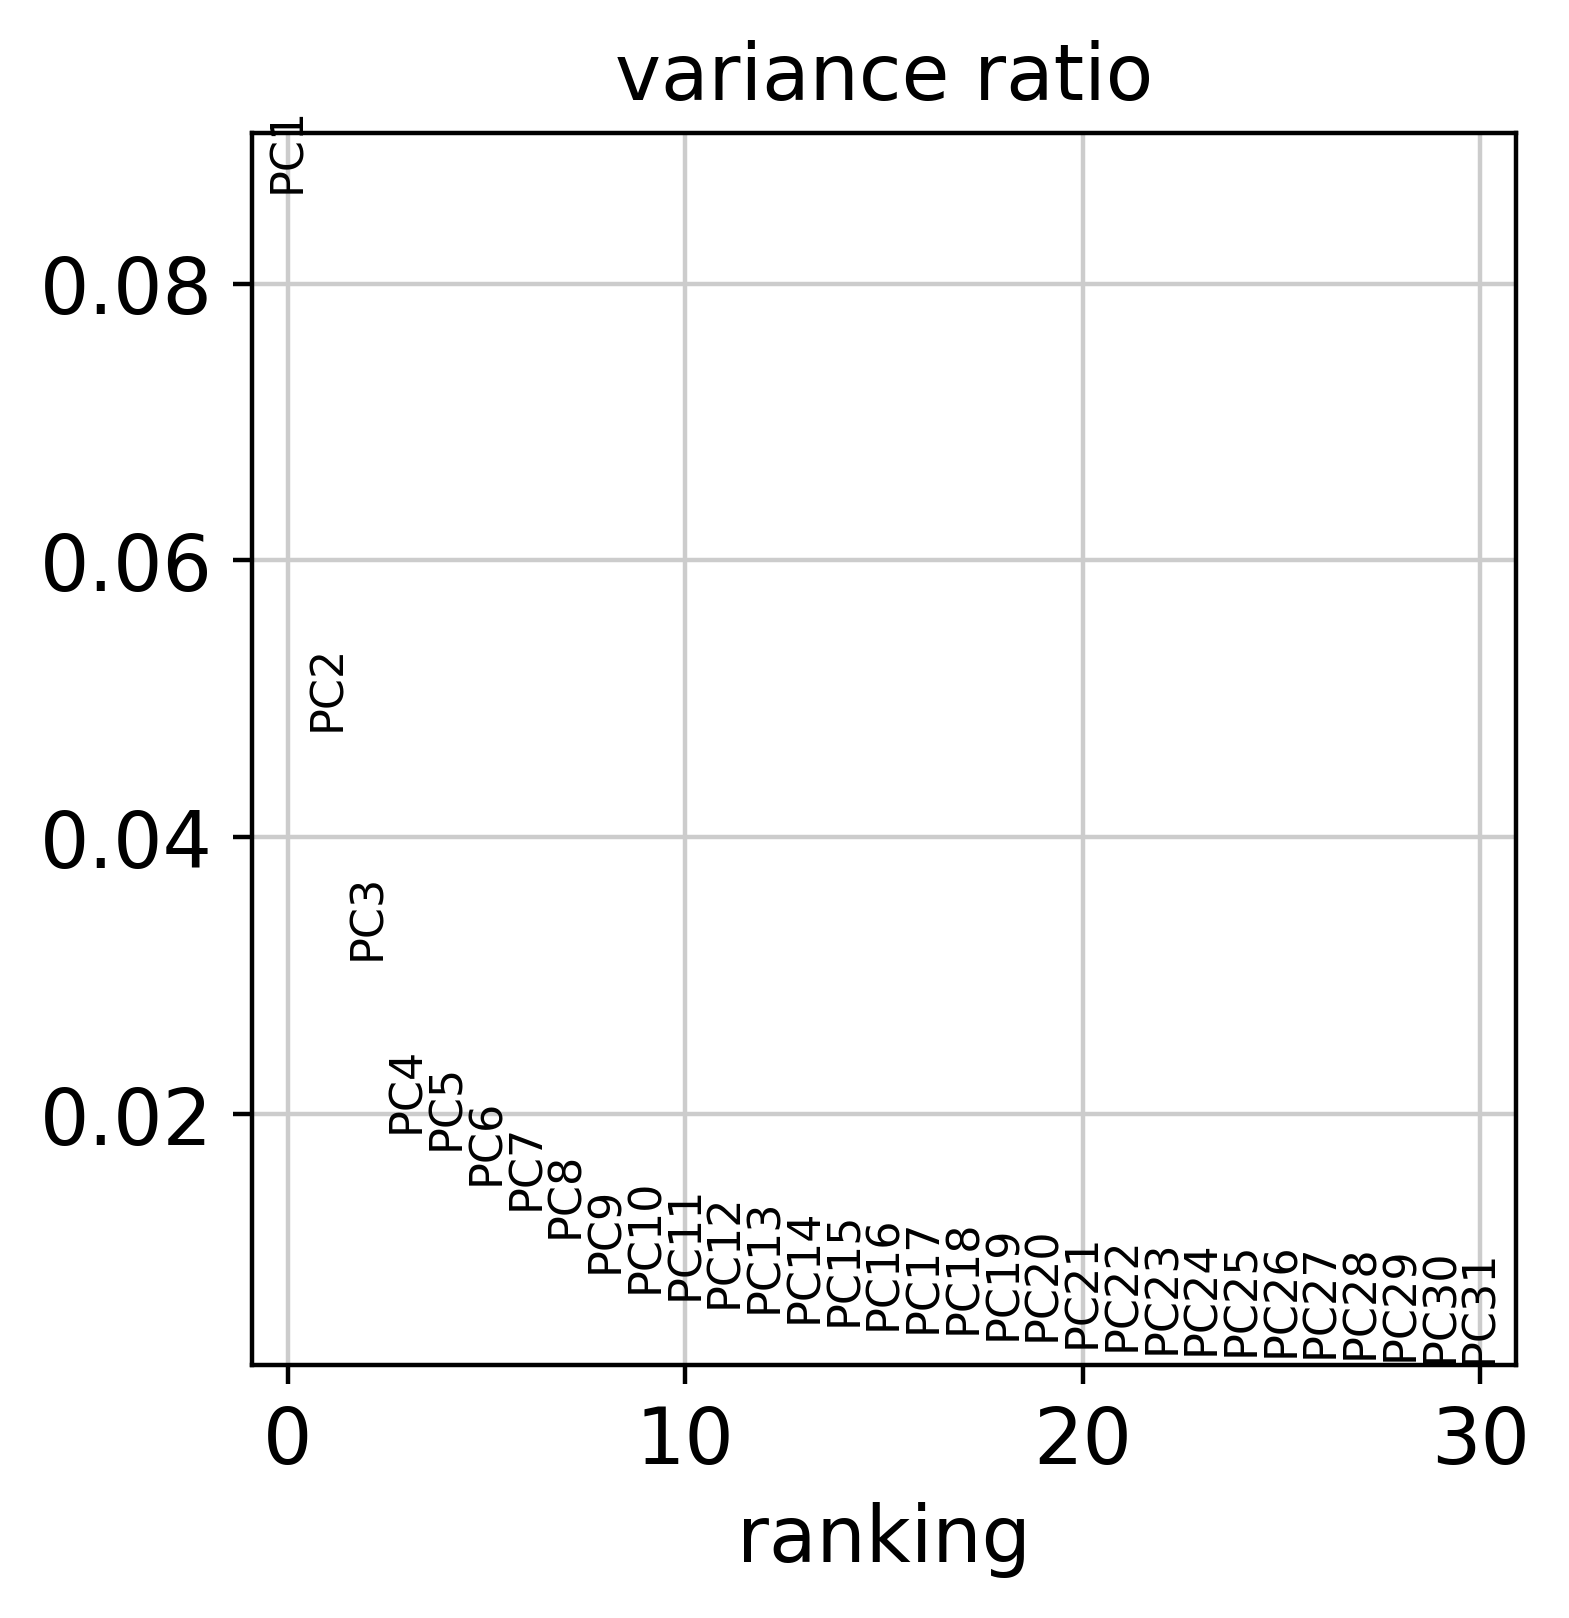

In [20]:
sc.pl.pca_variance_ratio(adata_test)

In [21]:
# Include PCs identified by elbow plot
adata.obsm['X_pca'] = adata.obsm['X_pca'][:,0:9]

In [24]:
%%R -i adata_test

# Determine if an unbiased _start or guided _startend approach is best

print("1:")
adata_test_start <- slingshot(adata_test, clusterLabels = 'clusters', reducedDim = 'PCA', start.clus='qRGC')
print(SlingshotDataSet(adata_test_start))

print("")
print("2:")
adata_test_startend <- slingshot(adata_test, clusterLabels = 'clusters', reducedDim = 'PCA', start.clus='qRGC', 
                            end.clus=c('Neuron-1', 'Interneuron-1'))
print(SlingshotDataSet(adata_test_startend))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
    2848          9

lineages: 1 
Lineage1: qRGC  IPC  Neuron-1  Interneuron-1  vRGC  

curves: 1 
Curve1: Length: 55.512	Samples: 2848
[1] ""
[1] "2:"
class: SlingshotDataSet 

 Samples Dimensions
    2848          9

lineages: 2 
Lineage1: qRGC  vRGC  Interneuron-1  
Lineage2: qRGC  IPC  Neuron-1  

curves: 2 
Curve1: Length: 45.398	Samples: 1199.62
Curve2: Length: 39.418	Samples: 2007.6
